## BEATLEX_adb Trial with test data: Summarizing and Forecasting Time Series with Patterns

### Abstract
Given time-series data such as electrocardiogram (ECG) readings, or motion capture data, how can we succintly summarize the data in a way that robustly identifies patterns that appear repeatedly? How can we then use such a summary to identify anomalies such as abnormal heartbeats, and also forecast future values of the time series? Our main idea is a vocabulary-based approach, which automatically learns a set of common patterns, or ‘beat patterns,’ which are used as building blocks to describe the time series in an intuitive and interpretable way. Our summarization algorithm, BEATLEX (BEAT LEXicons for Summarization) is: 1) fast and online, requiring linear time in the data size and bounded memory; 2) effective, outperforming competing algorithms in labelling accuracy by 5.3 times, and forecasting accuracy by 1.8 times; 3) principled and parameterfree, as it is based on the Minimum Description Length principle of summarizing the data by compressing it using as few bits as possible, and automatically tunes all its parameters; 4) general: it applies to any domain of time series data, and can make use of multidimensional (i.e. coevolving) time series.

You can configure the backend to use GPU or CPU only. \
Default is using backend cpu. 

In [3]:
import sys
sys.path.append("C:/Users/bailean/Documents/Bitbucket-Projects/spartan2")

import spartan as st
import pandas as pd 

```loadTensor``` function automatically read data from file and ```toDTensor``` function extract time and value separately from the tensor.<br/>```Timeseries``` class is designed to construct time tensor.

labels=Index(['  CurrentMMPPhase ', '  ESCBiasVoltage_AI V',
       '  TCPMatchCurrentPhaseDifference_AI deg', '  IB5Value '],
      dtype='object'), code doesn't want time label which must be firt usecols index


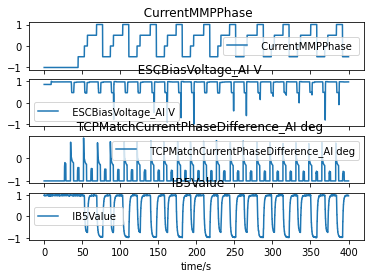

In [10]:
LRCXfilepath = 'inputData/LRCX-1/05-01-23_Dataset3_SJSUcase.csv'
kwargs = {
        'header': 0,
        'usecols': [0, 36, 38, 120, 77 ]
        }
df = pd.read_csv(LRCXfilepath)
labels = df.columns[kwargs['usecols'][1:]]
print(f"{labels=}, code doesn't want time label which must be firt usecols index")

time, value = st.loadTensor(path = LRCXfilepath, col_types = [float]*len(kwargs['usecols']), sep=',', **kwargs).toDTensor(hastticks=True)
time_series = st.Timeseries(value, time, labels = labels).normalize(inplace=False)

st.plot_timeseries(time_series.cut(0, 4000))

In [11]:
print(f"time series {time_series}, type {type(time_series)}")

         Time    CurrentMMPPhase     ESCBiasVoltage_AI V  \
0       0.097                -1.0               0.850993   
1       0.197                -1.0               0.850993   
2       0.297                -1.0               0.850993   
3       0.397                -1.0               0.850993   
4       0.497                -1.0               0.850993   
...       ...                 ...                    ...   
9038  903.897                 1.0               0.857064   
9039  903.997                 1.0               0.855408   
9040  904.097                 1.0               0.864238   
9041  904.197                 1.0               0.864238   
9042  904.297                 1.0               0.855408   

        TCPMatchCurrentPhaseDifference_AI deg    IB5Value   
0                                   -0.999880     0.977964  
1                                   -0.999880     0.977964  
2                                   -0.999880     0.950412  
3                                  

### Run Beatlex from specific task

In [4]:
ss_task = st.Summarization.create(time_series, st.SumPolicy.BeatLex, 'my_beatlex_model')

In [5]:
result = ss_task.run()

init at 298

========segment 2 at 299 598
cluster cost [0.00637887]
new cluster cost for 2: 0.01564196366332176
size chosen: 294
cluster 0

========segment 3 at 593 892
cluster cost [0.00286804]
new cluster cost for 2: 0.01564196366332176
size chosen: 292
cluster 0

========segment 4 at 885 1184
cluster cost [0.00174464]
new cluster cost for 2: 0.01564196366332176
size chosen: 284
cluster 0

========segment 5 at 1169 1468
cluster cost [0.0025184]
new cluster cost for 2: 0.01564196366332176
size chosen: 284
cluster 0

========segment 6 at 1453 1752
cluster cost [0.00166487]
new cluster cost for 2: 0.01564196366332176
size chosen: 284
cluster 0

========segment 7 at 1737 2036
cluster cost [0.00471445]
new cluster cost for 2: 0.01564196366332176
size chosen: 295
cluster 0

========segment 8 at 2032 2331
cluster cost [0.01229837]
new cluster cost for 2: 0.01564196366332176
size chosen: 235
new_cluster
best_place: [294, 0, 297]
best_S1: 294
new cluster starts 2032 ends 2326

========segment

c:\Users\bailean\AppData\Local\Programs\Python\Python310\lib\site-packages\spartan\model\beatlex\Beatlex.py:73: RuntimeWarning: All-NaN slice encountered
  best_cost = np.nanmin(ave_costs)


Sequence End Reached
best prefix found 9 nan 0.0019433397295321652
ending with prefix [8]


### Run Beatlex as a single model

In [12]:
beatlex = st.BeatLex(time_series)

In [13]:
result = beatlex.run()

init at 178

========segment 2 at 179 478
cluster cost [0.04846968]
new cluster cost for 4: 0.7777276690899291
size chosen: 180
cluster 0

========segment 3 at 359 658
cluster cost [0.13496918]
new cluster cost for 4: 0.7777276690899291
size chosen: 180
cluster 0

========segment 4 at 539 838
cluster cost [0.76350095]
new cluster cost for 4: 0.7777276690899291
size chosen: 180
new_cluster
best_place: [183, 1, 183]
best_S1: 183
new cluster starts 539 ends 722

========segment 5 at 723 1022
cluster cost [0.71884    0.32908501]
new cluster cost for 4: 0.7777276690899291
size chosen: 184
new_cluster
best_place: [179, 1, 180]
best_S1: 179
new cluster starts 723 ends 902

========segment 6 at 903 1202
cluster cost [0.91201198 0.16406703 0.49145677]
new cluster cost for 4: 0.7777276690899291
size chosen: 180
cluster 1

========segment 7 at 1083 1382
cluster cost [0.60314011 0.32081441 0.15781054]
new cluster cost for 4: 0.7777276690899291
size chosen: 180
cluster 2

========segment 8 at 1263 

c:\Users\bailean\AppData\Local\Programs\Python\Python310\lib\site-packages\spartan\model\beatlex\Beatlex.py:73: RuntimeWarning: All-NaN slice encountered
  best_cost = np.nanmin(ave_costs)


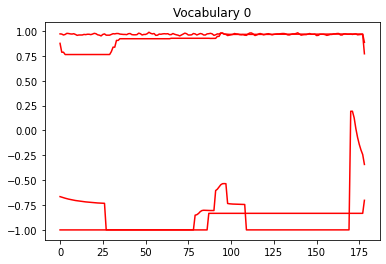

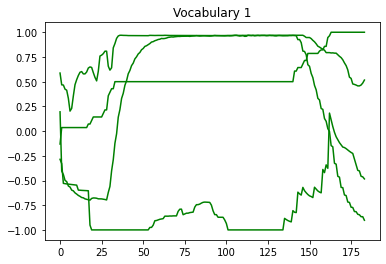

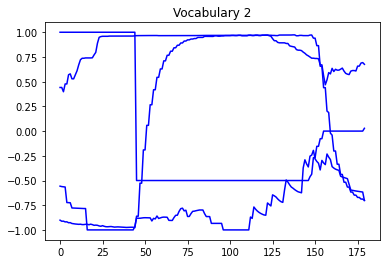

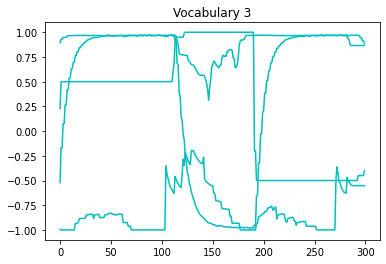

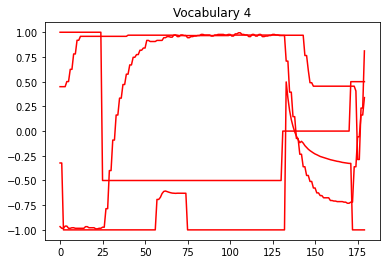

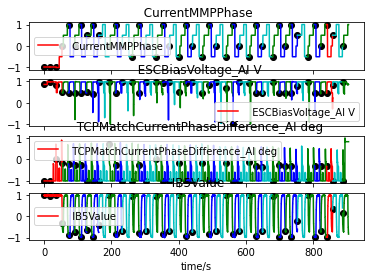

In [14]:
st.plot(st.BeatLex, time_series, result)

Vocabularies | Segmentation
:-------------------------:|:-------------------------:
<img src="images/beatlexSum1.png" width="300"/>  |   <img src="images/beatlexSum2.png" width="300"/>
<b>Vocabularies learned by BeatLex. |  <b>Segmentation made by BeatLex.

### Experiment Results
------
Beatlex(ECG)      |  Beatlex(Motion)
:-------------------------:|:-------------------------:
<img src="images/beatlexExp1.png" width="300"/>  |   <img src="images/beatlexExp2.png" width="300"/>
<b>Beatlex segments and labels data. |  <b>Beatlex learns vocabulary.

### Cite:
------
1. Hooi, Bryan, et al. "B eat L ex: Summarizing and Forecasting Time Series with Patterns." Joint European Conference on Machine Learning and Knowledge Discovery in Databases. Springer, Cham, 2017.

    <details>
    <summary><span style="color:blue">click for BibTex...</span></summary>

    ```bibtex
    @inproceedings{hooi2017b,
      title={B eat L ex: Summarizing and Forecasting Time Series with Patterns},
      author={Hooi, Bryan and Liu, Shenghua and Smailagic, Asim and Faloutsos, Christos},
      booktitle={Joint European Conference on Machine Learning and Knowledge Discovery in Databases},
      pages={3--19},
      year={2017},
      organization={Springer}
    }
    ```
    </details>